In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print(tf.__version__)

2.0.0-alpha0


In [2]:
data = pd.read_csv('5min_data.csv',encoding="gb2312")
data.columns=['date','open','high','low','close','volumn']  
data = pd.DataFrame(data,columns=['open','high','low','close','volumn'])
data.head()

,open,high,low,close,volumn
0,2551.81,2556.93,2551.81,2556.41,790880900
1,2557.12,2557.82,2544.57,2544.57,480816100
2,2543.33,2543.33,2538.50,2538.50,359649200
3,2538.76,2538.76,2534.36,2535.52,294182800
4,2535.29,2541.49,2535.18,2541.49,267944600


In [3]:
# 特征数量
features_num = len(data.columns) - 1
# 定义观察时间窗口120/170/220/270
observe_time = 120
# 定义预测时间窗口5/10/15
predict_time = 5
# 一组时间窗口
group_time = observe_time + predict_time

### 分割特征及标签

In [4]:
features,returns = list(),list()
for i in range(len(data.close)-group_time):
    features.append(np.array(data[i:i+observe_time]))
    returns.append(data.close[i+group_time]-data.close[i+observe_time])
features = np.array(features)
returns = np.array(returns)
print(features.shape,returns.shape)

(57515, 120, 5) (57515,)


### 分割训练集和测试集

In [5]:
alpha = 0.8
train_length = int(len(features)*alpha)

train_data = features[:train_length]
test_data = features[train_length:]

train_return = returns[:train_length]
test_return = returns[train_length:]

### 根据收益率实现三分类打标签

In [6]:
def segmentation(features,returns,per):
    neg_list,pos_list,mid_list = list(),list(),list()
    neg_value = round(float(sorted(returns)[int(len(returns)*per):int(len(returns)*per)+1][0]),2)
    pos_value = round(float(sorted(returns)[int(len(returns)*(1-per)):int(len(returns)*(1-per))+1][0]),2)
    mid_left_value = round(float(sorted(returns)[int(len(returns)*(0.5*(1-per))):int((len(returns)*(0.5*(1-per))))+1][0]),2)
    mid_right_value = round(float(sorted(returns)[int(len(returns)*(0.5*(1+per))):int((len(returns)*(0.5*(1+per))))+1][0]),2)
    print('正样本最小值:%.2f\t中样本范围:%.2f~%.2f\t负样本最大值:%.2f'%(pos_value,mid_left_value,mid_right_value,neg_value))
    data_x = list()
    data_y = list()
    for i in range(len(returns)):
        if returns[i]<=neg_value:
            data_x.append(features[i])
            data_y.append(0)
        elif mid_left_value<=returns[i]<=mid_right_value:
            data_x.append(features[i])
            data_y.append(1)            
        elif returns[i]>=pos_value:
            data_x.append(features[i])
            data_y.append(2)
        else:
            continue
    data_x = np.array(data_x)
    data_y = np.array(data_y)
    data_x = data_x.reshape(data_x.shape[0],data_x.shape[1],data_x.shape[2],1)
#     data_y = data_y.reshape(data_y.shape[0],1)
    return data_x,data_y

In [7]:
train_x,train_y = segmentation(train_data,train_return,per=0.1)
print(train_x.shape,train_y.shape)

正样本最小值:15.62	中样本范围:-0.90~1.40	负样本最大值:-14.11
(13804, 120, 5, 1) (13804,)


In [8]:
test_x,test_y = segmentation(test_data,test_return,per=0.1)
print(test_x.shape,test_y.shape)

正样本最小值:9.36	中样本范围:-0.61~1.08	负样本最大值:-8.36
(3453, 120, 5, 1) (3453,)


In [9]:
model = keras.Sequential()
model.add(layers.Conv2D(input_shape=(train_x.shape[1], train_x.shape[2], train_x.shape[3]),
                        filters=32, kernel_size=(3,3), strides=(1,1), padding='same',
                       activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2,2)))

In [10]:
model.add(layers.Conv2D(input_shape=(train_x.shape[1], train_x.shape[2], train_x.shape[3]),
                        filters=16, kernel_size=(3,3), strides=(1,1), padding='same',
                       activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

In [11]:
model.compile(optimizer=keras.optimizers.Adam(),
             # loss=keras.losses.CategoricalCrossentropy(),  # 需要使用to_categorical
             loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 120, 5, 32)        320       
_________________________________________________________________
batch_normalization_v2 (Batc (None, 120, 5, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 2, 32)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 2, 16)         4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 1, 16)         0         
_________________________________________________________________
flatten (Flatten)            (None, 480)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                7

In [15]:
history = model.fit(train_x, train_y, batch_size=64, epochs=20, validation_split=0.1)

Train on 12423 samples, validate on 1381 samples
Epoch 1/20
12423/12423 [==============================] - 12s 945us/sample - loss: 0.2995 - accuracy: 0.8684 - val_loss: 2.5745 - val_accuracy: 0.5663
Epoch 2/20
12423/12423 [==============================] - 11s 920us/sample - loss: 0.2915 - accuracy: 0.8718 - val_loss: 2.5551 - val_accuracy: 0.5163
Epoch 3/20
12423/12423 [==============================] - 11s 915us/sample - loss: 0.3228 - accuracy: 0.8586 - val_loss: 2.5275 - val_accuracy: 0.5590
Epoch 4/20
12423/12423 [==============================] - 11s 922us/sample - loss: 0.3166 - accuracy: 0.8640 - val_loss: 2.5916 - val_accuracy: 0.5409
Epoch 5/20
12423/12423 [==============================] - 13s 1ms/sample - loss: 0.3221 - accuracy: 0.8617 - val_loss: 2.3960 - val_accuracy: 0.5699
Epoch 6/20
12423/12423 [==============================] - 13s 1ms/sample - loss: 0.3169 - accuracy: 0.8609 - val_loss: 2.5433 - val_accuracy: 0.5467
Epoch 7/20
12423/12423 [=========================

<module 'matplotlib.pyplot' from 'c:\\users\\junming\\appdata\\local\\programs\\python\\python37\\lib\\site-packages\\matplotlib\\pyplot.py'>

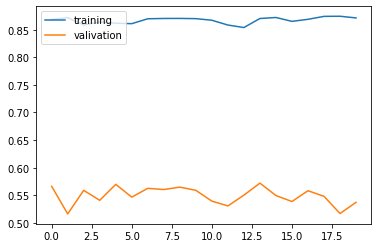

In [16]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'valivation'], loc='upper left')
plt

In [17]:
res = model.evaluate(test_x, test_y)

3453/3453 [==============================] - 0s 123us/sample - loss: 32.8889 - accuracy: 0.3695
